# 0. Theory

In 1932, Langmuir developed the Langmuir adsorption isotherm, which describes the adsorption and desorption of molecules on a surface \cite{langmuir1932vapor}.

Following the principles of physical chemistry for reaction kinetics and thermodynamics the change in the amount of solute adsorbed on a surface per unit area over time can be expressed in the following equation \cite{latour2015langmuir}.



$$\frac{dq}{dt} = k_aC(Q-q)-k_dq$$


where $C$ is the solution concentration, $Q$ is the amount of solute adsorbed when all of the biding sites are filled, $q$ is the amount of solute adsorbed on the surface given a solution concentration $C$, $t$ is the time and $(Q-q)$ is the number of vacant sites for adsorption.

Under dynamic equilibrium conditions, $dq/dt=0$, the equilibrium constant and $q$ are given by:

$$K_A=\frac{k_a}{k_d} = \frac{q}{C(Q-q)}$$

$$q =\frac{QC}{C+K_A^{-1}}$$

The following equation is used  to quantify adsorption coverage (i.e. normalized coverage $0<\Theta<1$).

$$\Theta = \frac{\text{Occupied region}}{\text{Total available region}} = \frac{q}{Q}=\frac{V_a}{V_m} = \frac{m_a}{m_m}$$

where $\Theta $ represents the coverage of the surface, $ V_a $ is the volume of the adsorbate adhered, $ V_m $ is the maximum volume of adsorbate in a monolayer, $ m_a $ is the number of moles adhered, and $ m_m $ is the maximum number of moles of adsorbate in a monolayer.

Then, the first order differential equation (i.e. Langmuir isotherm) in terms of the normalized coverage is:

$$\frac{d(q/Q)}{dt}=\frac{d\Theta}{dt} = k_aC(1-\Theta)-k_d\Theta$$

And has exponential solutions (i.e. $\Theta(t)$) given by:

   $$ \Theta(t) = \left(\frac{k_aC}{k_aC+k_d}\right)\left(1-e^{-({k_aC+k_d})t}\right), \quad \text{or}\quad
\Theta(t) = \left(\frac{C}{C+K_A^{-1}}\right)\left(1-e^{-({k_aC+k_d})t}\right)$$

The molecular surface under steady state conditions, from the previous equation is given by:

$$\Theta^\infty=\lim_{t\rightarrow\infty}\Theta(t)=\frac{C}{C+K_A^{-1}}$$




PINNS theory is the intersection between Machine Learning (ML) and Physics.

We can use PINNS in two main different approachs:

1. Give that we have enought data from the physical problem, we can use ML algorithms to discover the physical laws that governs that particulary data.
2. Give that we already know the physics relations, or we know some physics of the problem, we can enforce this physical property into our ML model, making a better physical model.

In this notbook, we gonna apply the second approach of PINNS to reproduce solution of the adsorption equation.

$$\frac{d\Theta}{dt} = f(\theta,t)$$
$$\Theta^\infty=\frac{C}{C+K_A^{-1}}$$

The PINN that we are about to train attempts to approxiamte the solution to a partial differential equation $\hat{\Theta}_{\gamma}(t,x)≈\Theta(t).$
where $\gamma$ are the parameters of the neural network.

The network is trained to minimize the residuum of the partial differential equation and the MSE error. The derivatives informations are obtained via higher-order input-output automatic differentiation of the neural network.

The typical architecture for PINNs are Multi-Layer Perceptrons whose input is $\theta$ and time $t$ (if applicable). The output of the network is the solution $\hat{\Theta}_{\gamma}(t,x)$ at the given position and time.

In our case, the parameters are found by minimizing the following composite loss:

$$\gamma^*=\text{arg} \;\underset{\gamma}{\text{min}}\;L(\gamma)=\text{arg}\;\underset{\gamma}{\text{min}}\left(L_{PDE}(\gamma) + L_{BC}(\gamma)\right)$$

With the PDE residuum given as the MSE of the residual at randomly sampled collocation points inside the domain

$$L_{PDE}(\gamma)=\frac{1}{2L}\sum_{i=1}^L\left(\frac{\partial \hat{\Theta}_{\gamma}}{\partial t}|_{t=t_i}-f(t_i)\right)^2$$

The boundary conditions given as the mean squared error of the solution at randomly sampled boundary points (In this approach, we can use only the left and right boundary points)

$$L_{BC}(\gamma) = \left(\hat{u_{\theta}}(\infty)-\frac{C}{C+K_A^{-1}}\right)^2$$



# **1. Import the libraries and constant definitions**

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import scipy as sp

# **2. Training data: Remake of the [Laborde2013](https://drive.google.com/file/d/10zcwdIOnThq-TFCDNz9GIXgnQdqsTU0a/view?usp=sharing) paper**

## 2.1 Fitting process

### 2.1.1 Finding $K_a$ and $\theta_\infty$

In [7]:
# Linearization

C_laborde = np.array([0.82e-4, 1.64e-4, 4e-4, 0.82e-3,2.05e-3]);
Theta_laborde = np.array([0.18, 0.31, 0.53, 0.87, 1])

C_laborde =  1/C_laborde
Theta_laborde = 1/Theta_laborde

In [8]:
# Defining the A matrix
a11 = np.sum(C_laborde**2); a12 = np.sum(C_laborde); a21 = np.sum(C_laborde); a22 = len(C_laborde)
A = np.array([[a11,a12],
             [a21,a22]])

# Defining the b matrix
b11 = np.sum(Theta_laborde*C_laborde); b21 = np.sum(Theta_laborde)
b = np.array([[b11],[b21]])

# Solving the system
x = np.linalg.solve(A,b)
ka_theta_inf,theta_inf_inv = x

theta_inf = 1/theta_inf_inv
Ka_inv = ka_theta_inf * theta_inf
Ka = 1/Ka_inv
# Defining the exponential f function

f_c = lambda C: (Ka*C/(1+Ka*C))*theta_inf

# Calculating the error
Theta_laborde = 1/Theta_laborde
C_laborde = 1/C_laborde
E = np.sum((f_c(C_laborde)-Theta_laborde)**2)

In [9]:
fitvalues = {
             'MSE': E,
             'K': Ka,
             'Theta_infty':theta_inf

}
pd.DataFrame(fitvalues)

,MSE,K,Theta_infty
0,0.008643,2032.728351,1.253658


In [29]:
plt.rc("axes", titlesize=14)  # Title font size
plt.rc("axes", labelsize=14)  # Label font size
plt.rc("xtick", labelsize=12)  # X-tick font size
plt.rc("ytick", labelsize=12)  # Y-tick font size
plt.rc("legend", fontsize=12)  # Legend font size

# Define a list of colors for each experiment
colors = [
    "blue",
    "green",
    "red",
    "orange",
    "purple",
    "brown",
    "pink",
    "cyan",
]  # Extend if needed

plt.rc("axes", titlesize=12, labelsize=12)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=9) # Slightly larger for readability in individual plots
plt.rc("font", family="times new roman", size=12)  # Use the default serif font

C:\Users\Rodrigo Toledo\AppData\Local\Temp\ipykernel_16496\3375599336.py:17: RuntimeWarning: divide by zero encountered in divide
  inner_ax.plot(1/C_test,1/FitTheta,label= f'Fitted | Keq = {Ka}')


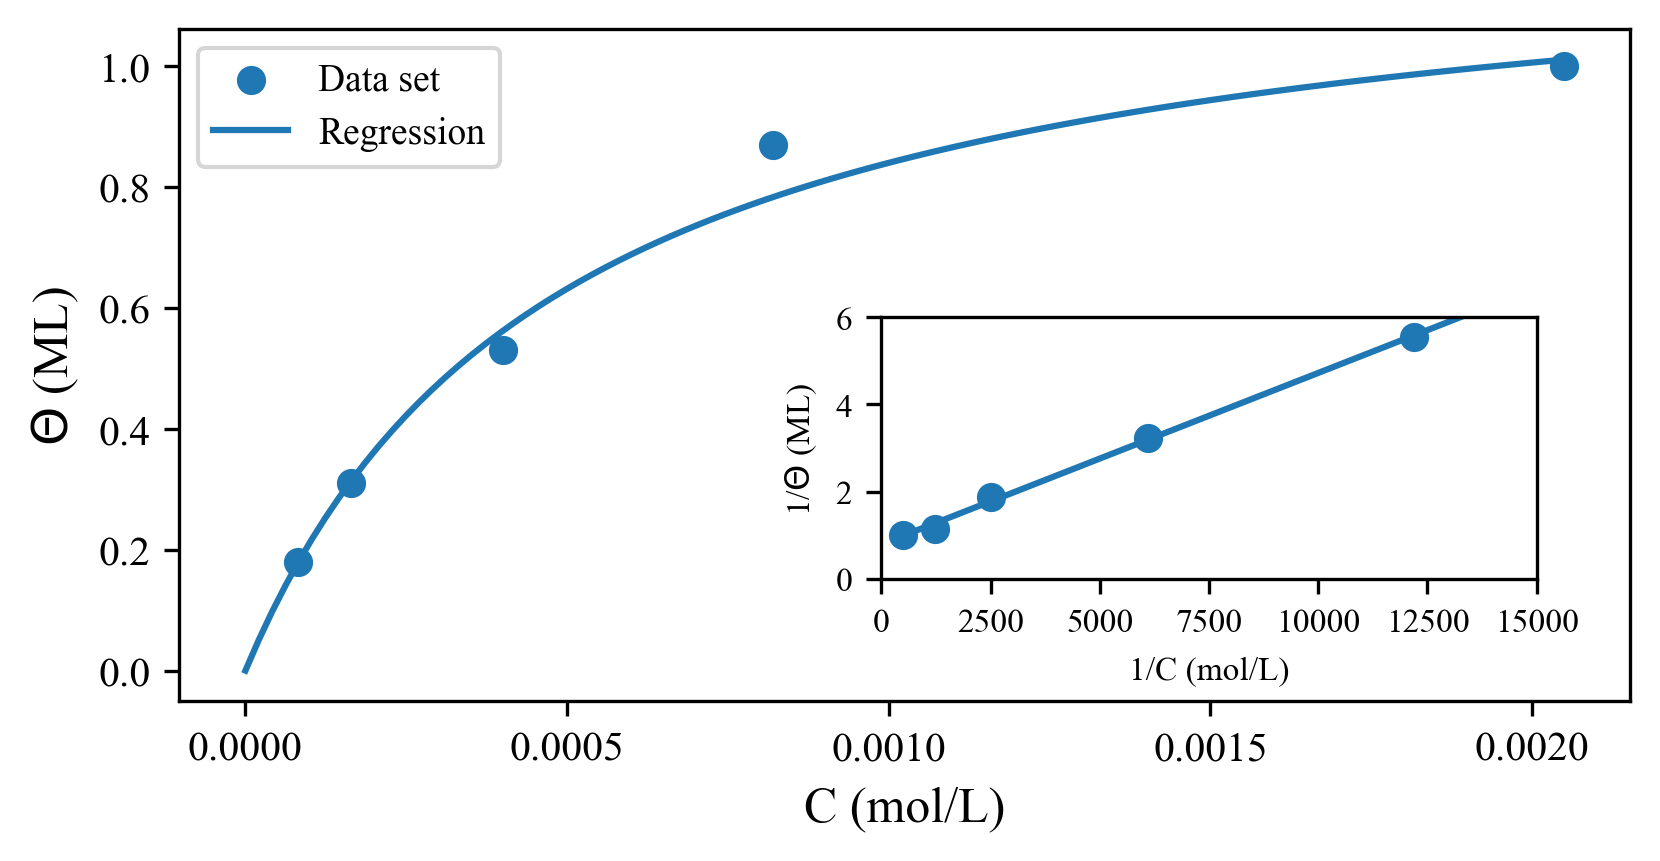

In [18]:
# Plotting the data
C_test = np.linspace(0,2.05e-3,100)
FitTheta = Ka*C_test/(1+Ka*C_test)*theta_inf
width_cm = 15.85
height_cm = 7.39
fig, ax = plt.subplots(figsize=(width_cm / 2.54, height_cm / 2.54), dpi=300)
ax.scatter(C_laborde,Theta_laborde, label = 'Data set')
ax.plot(C_test,FitTheta,label = f'Regression')
ax.set_xlabel('C (mol/L)')
ax.set_ylabel(r'$\Theta$ (ML)')
ax.legend()
ax.grid(visible=False)
inner_ax = fig.add_axes([0.5, 0.25, 0.35, 0.3]) # [left, bottom, width, height]
# Plot the inverse

inner_ax.scatter(1/C_laborde,1/Theta_laborde)
inner_ax.plot(1/C_test,1/FitTheta,label= f'Fitted | Keq = {Ka}')
inner_ax.grid(visible=False)
inner_ax.set_xlabel('1/C (mol/L)',fontsize=8)
inner_ax.set_ylabel(r'1/$\Theta$ (ML)',fontsize=8)
inner_ax.set_xlim(0,15000)
inner_ax.set_ylim(0,6)
#inner_ax.legend()
# Adjust the tick label sizes
inner_ax.tick_params(axis='x', labelsize=8)
inner_ax.tick_params(axis='y', labelsize=8)
plt.savefig('BiotinPlots/Regression.svg', bbox_inches='tight', transparent=True)

### 2.1.2 Finding ka and kd

In [19]:
def fit_thermodynamic_parameters(Theta_exp, C_exp, initial_guess):
    def model(params):
        ka, kd = params
        Theta = (ka * C_exp / (kd + ka * C_exp)) * 1.253658
        return Theta

    def objective_function(params):
        Theta_model = model(params)
        MSE = np.mean((Theta_model - Theta_exp) ** 2)
        return MSE

    # Define the constraint ka / kd = 2032.728351
    def constraint(params):
        ka, kd = params
        return ka / kd - 2032.728351

    # Initial guess for ka and kd
    ka_initial, kd_initial = initial_guess

    # Constraints dictionary for scipy.optimize.minimize
    constraints = {'type': 'eq', 'fun': constraint}

    # Perform the optimization
    result = minimize(objective_function, [ka_initial, kd_initial], method='SLSQP', constraints=constraints)

    # Extract the optimized parameters
    ka_opt, kd_opt = result.x
    mse = result.fun

    return ka_opt, kd_opt, mse

In [20]:
# Initial guesses for ka and kd
initial_guess = [160,5.44e-2]
ka_opt, kd_opt, mse = fit_thermodynamic_parameters(Theta_laborde,C_laborde,initial_guess)

In [21]:
fitvalues = {
             'MSE': [mse],
             'ka': [ka_opt],
             'kd': [kd_opt],
}
pd.DataFrame(fitvalues)

,MSE,ka,kd
0,0.001729,159.99999,0.078712


In [22]:
# Defining Langmuir isotherm function

def Langmuir_Isotherm(Theta,t,C,const):
      ka, kd = const
      dTheta = ka*C*(1-Theta/theta_inf) - kd*Theta
      return dTheta

From a 4-layer Fresnel formulation, the expression for the effective refractive index and the refractive index variation of a thin ad-layer with thickness $d_3$ is given by:


$$\mathcal{N}_s^{\text{eff}}=\frac{2\pi d_3}{\lambda}\frac{\left(-\varepsilon_{2r}\mathcal{N}_4^2\right)^{1/2}}{\left(\varepsilon_{2r}-\mathcal{N}_4^2\right)^2}\frac{\mathcal{N}_3^2-\mathcal{N}_4^2}{\mathcal{N}_3^2} + \mathcal{N}_4^2$$

$$\Delta \mathcal{N}_s^{\text{eff}} = \mathcal{N}_s^{\text{eff}} - \mathcal{N}_4$$

Where the effective refractive index variation $\Delta \mathcal{N}_s^{\text{eff}}$ can be estimated by using the surface coverage (i.e., $\Theta_{\text{mol}}(C_s)$, derived from one of the adsorption models) as shown in the following equation:

$$\Delta \mathcal{N}_s^{\text{eff}}(C_s) = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\Theta_{\text{mol}}(C_s)$$

where $\mathcal{N}_{\text{mol}}^{\text{max}}$ is denoted as the ideal maximum achievable refractive index variation (i.e., Assuming complete and homogeneous surface coverage $\Theta_{\text{mol}}=1$).

Inversely, the thickness $d_3$ of the molecular film can be estimated by:

$$d_3=\Delta \mathcal{N}_s^{\text{eff}}\frac{\lambda}{2\pi}\frac{\left(\varepsilon_{2r}-\mathcal{N}_4^2\right)^2}{\left(-\varepsilon_{2r}\mathcal{N}_4^2\right)^{1/2}}\frac{\mathcal{N}_3^2}{\mathcal{N}_3^2-\mathcal{N}_4^2}$$
  

In [23]:
# Defining the structure parameters
lambdaa=670e-9;
emr=-14.6;
n3=1.557;
n4=1.339;

frac1=((emr-n4**2)**2)/((-emr*n4**2)**(3/2))
frac2=n3**2/(n3**2-n4**2)

In [24]:
# Defining the conditions
t1 = np.linspace(0,20,1000)
Theta_0 = 0; C = 2.05e-3; Delta_n=0.96e-3
const_b = [ka_opt, kd_opt];

In [26]:
Theta = sp.integrate.odeint(Langmuir_Isotherm, Theta_0, t1, args=(C, const_b))
Delta = Delta_n*Theta
d3 = Delta*(lambdaa/(2*np.pi))*frac1*frac2

In [27]:
dTheta = Langmuir_Isotherm(Theta,t1,C,const_b)

<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Rodrigo Toledo\AppData\Local\Temp\ipykernel_16496\2569079593.py:14: SyntaxWarning: invalid escape sequence '\T'
  ax1.plot(t1[-1], Theta[-1], 'ro', label='$\Theta_{\infty}$' + r': {:.2f}ML'.format(Theta[-1][0]))
C:\Users\Rodrigo Toledo\AppData\Local\Temp\ipykernel_16496\2569079593.py:21: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(t1[-1], 1e3 * Delta[-1], 'ro', label='$\Delta n_s^{eff}\infty$' + r': {:.2f}mRIU'.format(1e3 * Delta[-1][0]))
C:\Users\Rodrigo Toledo\AppData\Local\Temp\ipykernel_16496\2569079593.py:30: SyntaxWarning: invalid escape sequence '\i'
  ax3.plot(t1[-1], d3[-1] * 1e9, 'ro', label='$d_{3_\infty}$:' + r'{:.2f}nm'.format(d3[-1][0] * 1e9))


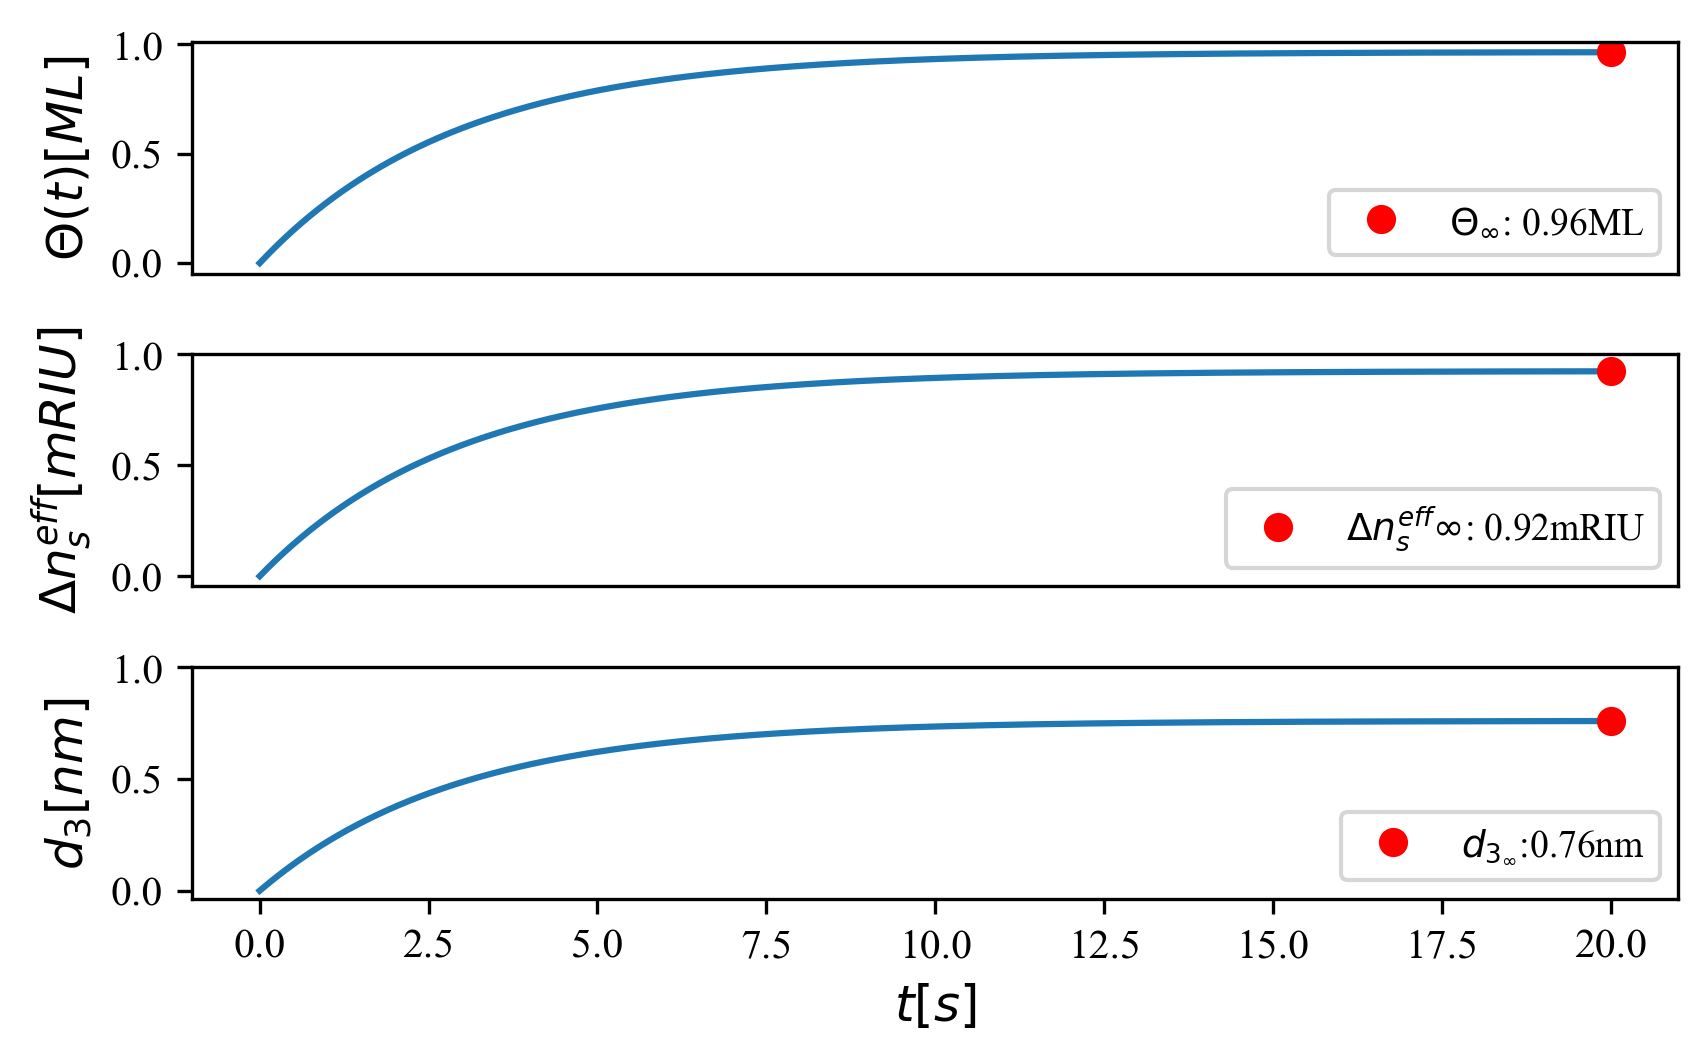

In [28]:
# Convert centimeters to inches for figsize
width_cm = 14.87
height_cm = 9.4
width_in = width_cm / 2.54
height_in = height_cm / 2.54

# Create a figure with 3 subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(width_in, height_in), dpi=300)

# Plot for the first subplot (ax1)
ax1.plot(t1, Theta)
ax1.set_ylabel(r'$\Theta(t) [ML]$')
ax1.set_yticks([0, 0.5, 1])
ax1.plot(t1[-1], Theta[-1], 'ro', label='$\Theta_{\infty}$' + r': {:.2f}ML'.format(Theta[-1][0]))
ax1.legend(loc='lower right')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Hide x-axis labels

# Plot for the second subplot (ax2)
ax2.plot(t1, 1e3 * Delta)
ax2.set_ylabel(r'$\Delta n_s^{eff} [mRIU]$')
ax2.plot(t1[-1], 1e3 * Delta[-1], 'ro', label='$\Delta n_s^{eff}\infty$' + r': {:.2f}mRIU'.format(1e3 * Delta[-1][0]))
ax2.legend(loc='lower right')
ax2.set_yticks([0, 0.5, 1])
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Hide x-axis labels

# Plot for the third subplot (ax3)
ax3.plot(t1, d3 * 1e9)
ax3.set_ylabel(r'$d_3 [nm]$')
ax3.set_xlabel(r'$t[s]$')
ax3.plot(t1[-1], d3[-1] * 1e9, 'ro', label='$d_{3_\infty}$:' + r'{:.2f}nm'.format(d3[-1][0] * 1e9))
ax3.legend(loc='lower right')
ax3.set_yticks([0, 0.5, 1])

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('BiotinPlots/sensorgram_predicted.svg', bbox_inches='tight', transparent=True)

# **3. Defining the neural network**

## 3.2 By using the build from "scratch" Neural Networks

In [21]:
class Layer(eqx.Module):
    weight: jnp.ndarray
    bias: jnp.ndarray

    def __init__(self, in_features, out_features, key, use_bias=True):
        lim = 1 / jnp.sqrt(in_features)
        wkey, bkey = jax.random.split(key, 2)
        self.weight = jrandom.uniform(wkey, (out_features, in_features),
                                       dtype=jnp.float32) * 2 * lim - lim
        self.bias = jrandom.uniform(bkey, (out_features,),
                                     dtype=jnp.float32) * 2 * lim - lim if use_bias else None

    def __call__(self, x):
        y = self.weight @ x
        if self.bias is not None:
            y = y + self.bias
        return y

class SimpleMLP(eqx.Module):
    layers: List[Layer]
    activation: Callable[[jnp.ndarray], jnp.ndarray]

    def __init__(self, layers_sizes, key, use_bias=True, activation=jnp.tanh):
        self.layers = []
        self.activation = activation

        for i in range(1, len(layers_sizes)):
            layer = Layer(layers_sizes[i - 1], layers_sizes[i], key, use_bias)
            self.layers.append(layer)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jnp.broadcast_to(x, (1,))
            x = layer(x)
            x = self.activation(x)

        x = self.layers[-1](x)

        return jnp.squeeze(x)

In [22]:
# First we need to set a random key for reproducibility

key = jax.random.PRNGKey(42)
key, init_key = jax.random.split(key)
# Defining the Neural Network
pinn = SimpleMLP(key=key,use_bias=True,layers_sizes=[1, 20, 1])

# **4. Defining the loss function**

In our case, the parameters are found by minimizing the following composite loss:

$$\gamma^*=\text{arg} \;\underset{\gamma}{\text{min}}\;L(\gamma)=\text{arg}\;\underset{\gamma}{\text{min}}\left(L_{PDE}(\gamma) + L_{BC}(\gamma)\right)$$

With the PDE residuum given as the MSE of the residual at randomly sampled collocation points inside the domain

$$L_{PDE}(\gamma)=\frac{1}{2L}\sum_{i=1}^L\left(\frac{\partial \hat{\Theta}_{\gamma}}{\partial t}|_{t=t_i}-f(t_i)\right)^2$$

The boundary conditions given as the mean squared error of the solution at randomly sampled boundary points (In this approach, we can use only the left and right boundary points)

$$L_{BC}(\gamma) = \left(\hat{u_{\theta}}(\infty)-\frac{C}{C+K_A^{-1}}\right)^2$$

In [23]:
# Defining the f function
def time_to_index(time_value, start_time, end_time, num_elements):
    index = jnp.array((time_value - start_time) / (end_time - start_time) * (num_elements - 1),int)
    return index

def f(t, dtheta):
    index = time_to_index(t, 0, 20, 1000)
    return dtheta[index]

In [24]:
# Defining the PDE residuum (We gonna need to calculate the second derivative of the NN)

def PDE_Residuum(model, t, dtheta):
    model_residuum = jnp.abs(jax.grad(model)(t) - f(t, dtheta))
    return model_residuum

In [25]:
# Defining the loss function
# We need to compute the compond loss

def loss_f(model, t, dtheta):
    #PDE
    PDE_part = jax.vmap(PDE_Residuum, in_axes = (None, 0, None))(model, t, dtheta)
    Loss_PDE = 1/2 * jnp.mean(jnp.square(PDE_part))

    #BC
    BC_part = 1/2 * jnp.square(jnp.abs(model(t[-1]) - Theta[-1])) + 1/2 * jnp.square(jnp.abs(model(t[0]) - 0))

    Loss = Loss_PDE + BC_part
    #Complete loss
    return Loss[0]

# **5. Defining the optimization problem**

The optimization problem consists in find the best parameters (weights and bias in the context of Feed foward neural network) by applying a iterative numerical method (e.g., the gradiend descent), that minimizes a objective function (e.g. the loss function)

In [26]:
# Defining the optimizer
LEARNING_RATE=1e-4
opt = optax.adam(LEARNING_RATE)


# Defining the initial optimizer state
opt_state = opt.init(eqx.filter(pinn, eqx.is_array)) # We use eqx.filter because we want to extract the pure arrays from the model(check in the input is an array)

In [27]:
# Apply the optimization algorithm (we need the gradiens of the parameters, then we apply the optimization function and update the parameters, then we apply the parameters to the network)
@eqx.filter_jit
def make_step(model,x,theta,state):
    # We calculate the loss and the gradients of the parameters
    loss, params_grad = eqx.filter_value_and_grad(loss_f)(model,x,theta)
    # Calculation of the updated parameters
    updated_params, new_state = opt.update(params_grad, state, model)
    # Apply the updated parameters to the neural network
    updated_model = eqx.apply_updates(model,updated_params)

    return updated_model, new_state, loss, updated_params

# **6. Making the for loop**

In [28]:
# first, we need to declare a loss list
loss_list = []
parameter_list = []
pinns = []
epoch = 0
loss = 1

In [29]:
# Making the for loop until the loss in smaller than 1e-8 or the number of epochs have reached a treashold
while loss > 9.9e-9:
    # We need to make the optimization process at each epoch
    pinn, opt_state, loss, updated_params = make_step(pinn, t1,jnp.array(dTheta),opt_state)
    loss_list.append(loss);parameter_list.append(updated_params);pinns.append(pinn)
    epoch += 1
    if epoch % 1000 == 0:
      print(f'At epoch {epoch}, the loss is: {loss}')

At epoch 1000, the loss is: 0.08922464400529861
At epoch 2000, the loss is: 0.007739876862615347
At epoch 3000, the loss is: 0.003322993405163288
At epoch 4000, the loss is: 0.00205947645008564
At epoch 5000, the loss is: 0.0011025418061763048
At epoch 6000, the loss is: 0.0004987166612409055
At epoch 7000, the loss is: 0.0002029464376391843
At epoch 8000, the loss is: 7.219547842396423e-05
At epoch 9000, the loss is: 2.0516945369308814e-05
At epoch 10000, the loss is: 5.7055858633248135e-06
At epoch 11000, the loss is: 1.942484914252418e-06
At epoch 12000, the loss is: 1.2400925015754183e-06
At epoch 13000, the loss is: 9.959586577679147e-07
At epoch 14000, the loss is: 8.345726314473723e-07
At epoch 15000, the loss is: 7.154514491958253e-07
At epoch 16000, the loss is: 6.02233512836392e-07
At epoch 17000, the loss is: 4.694059327903233e-07
At epoch 18000, the loss is: 3.220126529868139e-07
At epoch 19000, the loss is: 1.7784920203212096e-07
At epoch 20000, the loss is: 7.576196026093

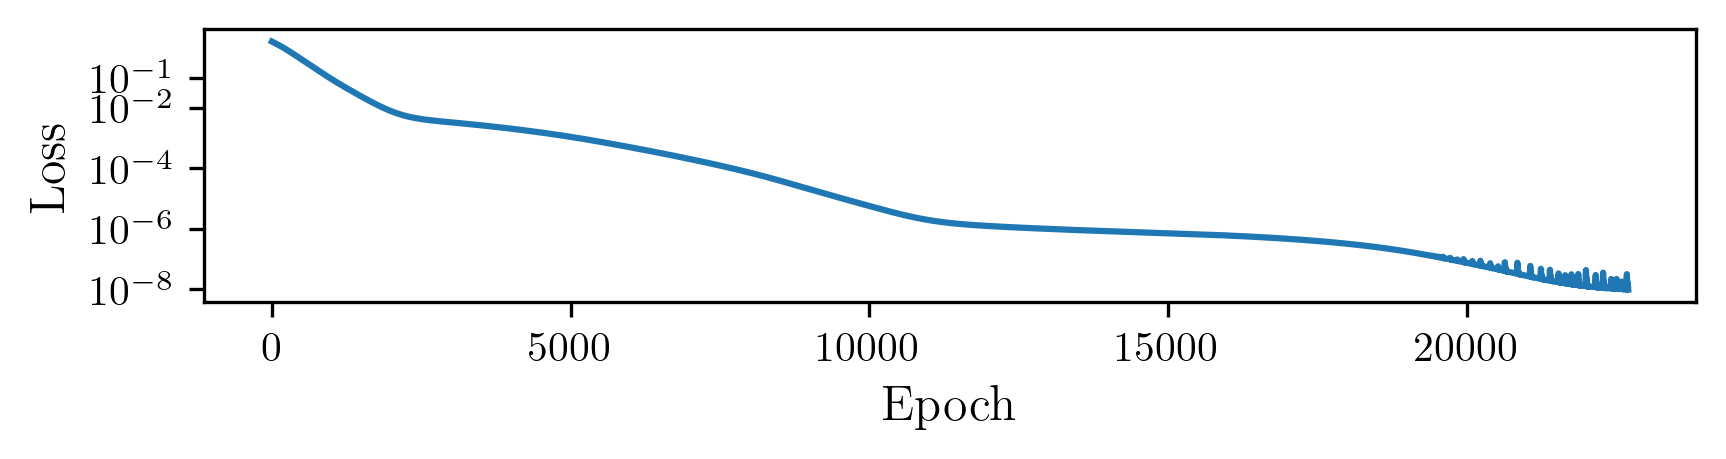

In [30]:
fig_loss, ax_loss = plt.subplots(figsize = (6.417,1.1811), dpi = 300)
Epochs = jnp.arange(0, epoch)
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_yscale('log')
ax_loss.set_yticks([1e-1,1e-2,1e-4,1e-6,1e-8])
ax_loss.plot(Epochs, loss_list)

In [31]:
loss,Epochs[-1]

(Array(9.800482e-09, dtype=float32), Array(22706, dtype=int32))

In [32]:
fig_loss.savefig('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/Loss_PINN.pdf', bbox_inches='tight')
files.download('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/Loss_PINN.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Applying the result

In [33]:
Thetas = [Theta, jax.vmap(pinn)(t1)]
solutions = ['Exact', 'PINNs']
Deltas = []
d3s = []
for theta in Thetas:
  Delta = Delta_n*theta
  d3 = Delta*(lambdaa/(2*np.pi))*frac1*frac2
  Deltas.append(Delta);d3s.append(d3)

# **8. Plotting the result**

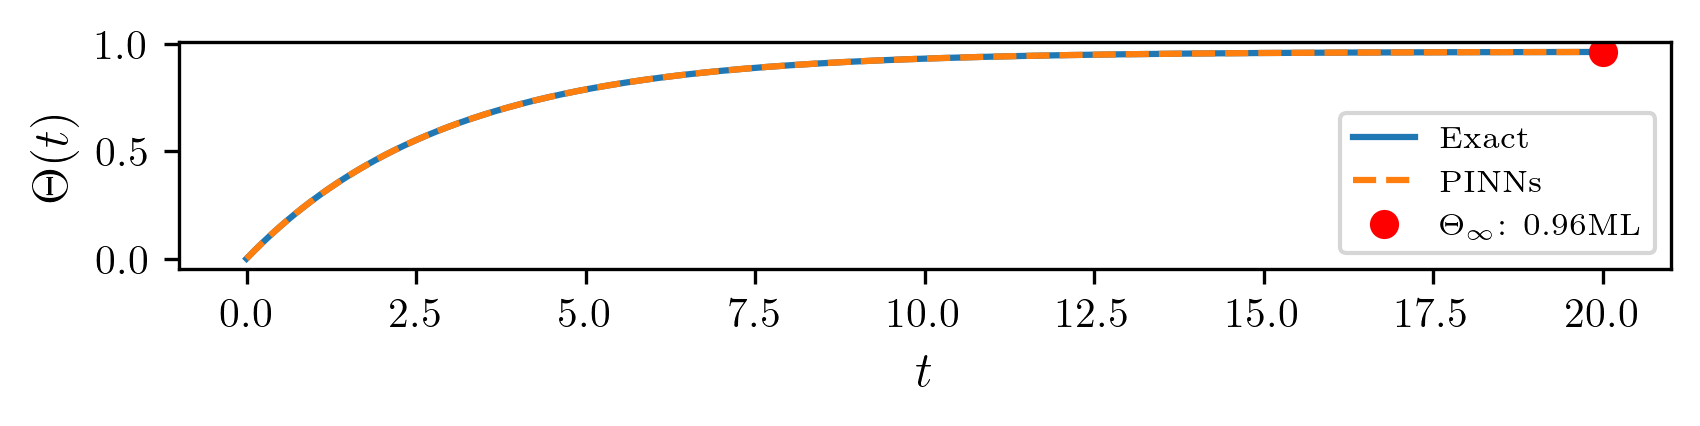

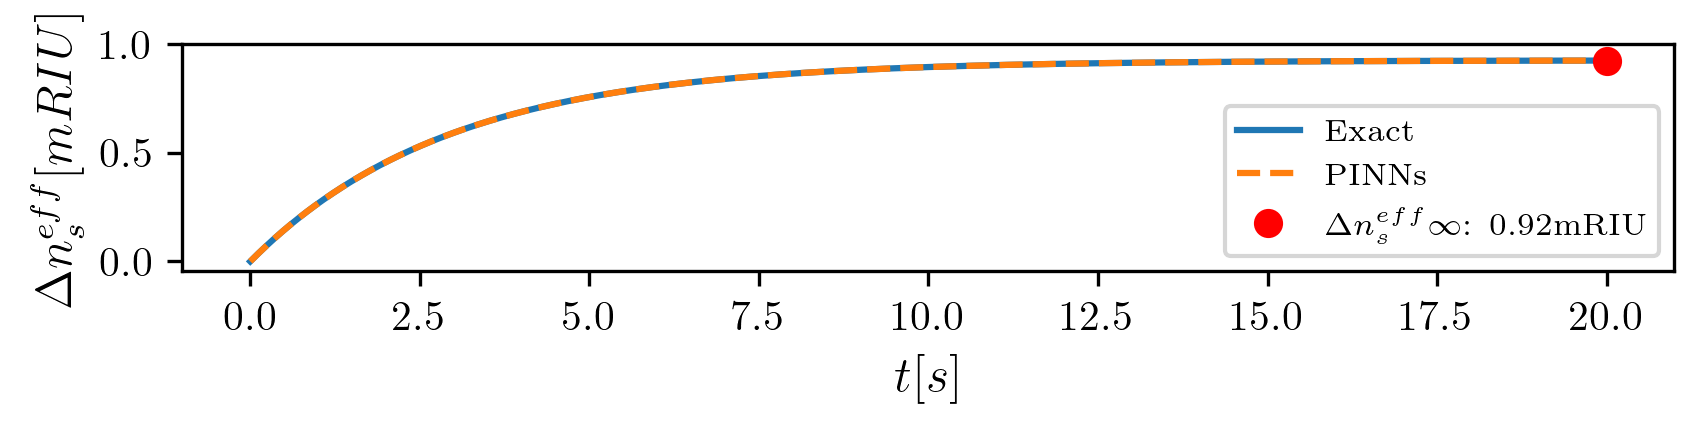

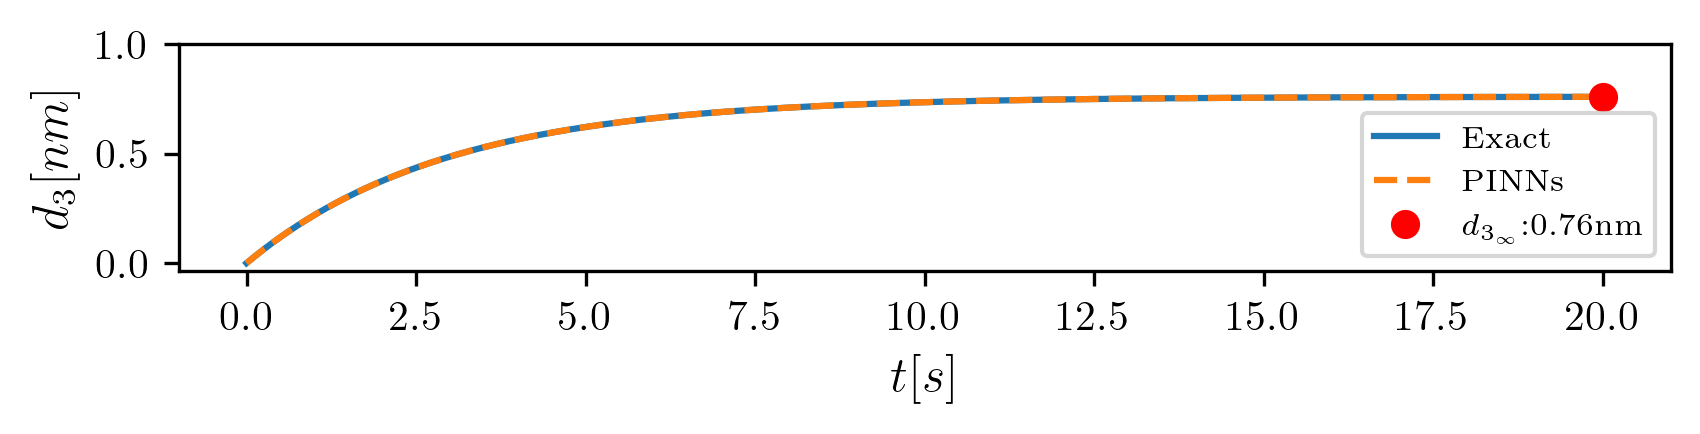

In [34]:
# Setting the figures and axes
# Theta
fig_pinn, ax_pinn = plt.subplots(figsize = (6.417,0.984252), dpi = 300)
ax_pinn.set_xlabel(r'$t$')
ax_pinn.set_ylabel(r'$\Theta(t)$')

# Delta
fig2, (ax2) = plt.subplots(figsize = (6.417,0.984252), dpi=300)
ax2.set_ylabel(r'$\Delta n_s^{eff} [mRIU]$')
ax2.set_xlabel(r'$t[s]$')

# d3
fig3, (ax3) = plt.subplots(figsize = (6.417,0.984252), dpi=300)
ax3.set_ylabel(r'$d_3 [nm]$')
ax3.set_xlabel(r'$t[s]$')

for i, solution in enumerate(solutions):
  # Plotting the theta
  if solution == 'PINNs':
    ax_pinn.plot(t1, Thetas[i], label = solution, linestyle ='dashed')
    # Plotting the delta
    ax2.plot(t1, 1e3 * Deltas[i], label = solution, linestyle ='dashed')
    # Plotting the d3
    ax3.plot(t1, d3s[i] * 1e9,label = solution, linestyle ='dashed')
  else:
    ax_pinn.plot(t1, Thetas[i], label = solution)
    # Plotting the delta
    ax2.plot(t1, 1e3 * Deltas[i], label = solution)
    # Plotting the d3
    ax3.plot(t1, d3s[i] * 1e9,label = solution)


ax_pinn.plot(t1[-1], Theta[-1], 'ro', label='$\Theta_{\infty}$'+ r': {:.2f}ML'.format(Theta[-1][0]))
ax_pinn.set_yticks([0,0.5,1])
ax_pinn.legend(fontsize = 7.5,loc = 'lower right')

last_value_delta = r'$\Delta n_s^{eff}\infty$: 0.96mRIU'
ax2.plot(t1[-1], 1e3 * Deltas[0][-1], 'ro', label='$\Delta n_s^{eff}\infty$'+r': {:.2f}mRIU'.format(1e3 * Deltas[0][-1][0]))
ax2.set_yticks([0,0.5,1])
ax2.legend(fontsize = 7.5)

last_value_d3 = r'$d_{3\infty}$: 0.79nm'
ax3.plot(t1[-1], d3s[0][-1] * 1e9, 'ro', label='$d_{3_\infty}$:'+r'{:.2f}nm'.format(d3s[0][-1][0]* 1e9))
ax3.legend(fontsize = 7.5)
ax3.set_yticks([0,0.5,1])

In [35]:
# fig_pinn.savefig('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/ThetaBiotinPinn.png', bbox_inches='tight')
# files.download('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/ThetaBiotinPinn.png')
# fig2.savefig('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/RIBiotinPinn.png', bbox_inches='tight')
# files.download('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/RIBiotinPinn.png')
# fig3.savefig('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/d3BiotinPinn.png', bbox_inches='tight')
# files.download('/content/drive/MyDrive/UFCG/Mestrado/DissertationPlots/d3BiotinPinn.png')

# 9. Error Analysis

In [52]:
# Error analysis between laborde and my values
#Error_Theta
Error_Theta = (np.abs(Theta_laborde[-1] - Thetas[0][-1])/Theta_laborde[-1])*100
#Error delta
Error_Delta = (np.abs(Delta_n - Deltas[0][-1])/Deltas[0][-1])*100
#Error thick
dLaborde = Delta_n*(lambdaa/(2*np.pi))*frac1*frac2
Error_d3 = (np.abs(dLaborde- d3s[0][-1])/dLaborde)*100
# Error from constants Ka, ka and kd
Error_Ka = (np.abs(2940 - Ka)/2940)*100
Error_ka = (np.abs(160-ka_opt)/160)*100
Error_kd = (np.abs(5.44e-2-kd_opt)/kd_opt)*100
Error_thetainf= (np.abs(1.2-theta_inf)/1.2)*100

In [53]:
# make a dataframe with all the errors
errors_df = {'Theta': Error_Theta,
                          'Delta': Error_Delta,
                          'd3': Error_d3,
                          'Ka': Error_Ka,
                          'ka': Error_ka,
                          'kd': Error_kd}
errors_df = pd.DataFrame(errors_df, index=['Error (%)'])
errors_df

,Theta,Delta,d3,Ka,ka,kd
Error (%),3.734139,3.878986,3.734139,30.85958,0.000006,30.887232


In [54]:
# Error analysis between my values and PINNs values

#Error_Theta
Error_ThetaPINN = (np.abs(Thetas[0][-1]-Thetas[1][-1])/Thetas[0][-1])*100
#Error delta
Error_DeltaPINN = (np.abs(Deltas[0][-1]-Deltas[1][-1])/Deltas[0][-1])*100
#Error thick
Error_d3PINN = (np.abs(d3s[0][-1]-d3s[1][-1])/d3s[0][-1])*100

In [56]:
# Make a dataframe with all the errors from PINNs
errorsPINN_df = {'Theta': Error_ThetaPINN,
                          'Delta': Error_DeltaPINN,
                          'd3': Error_d3PINN}
errorsPINN_df = pd.DataFrame(errorsPINN_df, index=['Error (%)'])
errorsPINN_df

,Theta,Delta,d3
Error (%),0.002563,0.00257,0.002566
